In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# import csv and map image of nyc
df = pd.read_csv( 'https://raw.githubusercontent.com/rselent/this_was_a_test/master/AB_NYC_2019.csv')
nyc_map = mpimg.imread( 'https://raw.githubusercontent.com/rselent/this_was_a_test/master/New_York_City_2.png')

# rename columns for easier readability, especially in visualizations
#   neighbourhood_group -> Borough
#   room_type -> Style
df = df.rename( columns= {'neighbourhood_group':'Borough', 
                          'room_type':'Style'})

# non-destructive drop of columns that I found irrelevant
df1 = df.drop( columns= {'host_name', 'number_of_reviews', 'last_review', 
                         'reviews_per_month', 'calculated_host_listings_count'})

# display / verify shapes of pre- and post-drop dataframes as well as a sample
#   (first 5 observations) of the post-drop dataframe, df1
print( df.shape)
print( df1.shape)
df1.head()

(48895, 16)
(48895, 11)


,id,name,host_id,Borough,neighbourhood,latitude,longitude,Style,price,minimum_nights,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,365
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,0


In [3]:
# Instead of just writing code to draw each visualization in separate notebook
# cells like we were taught, I want to show off a bit and construct functions 
# for each visualization and then call them in later cells

#
#

# draw an image (city map of nyc) underneath scatter plot: 
#   pass in the dataframe you want to use,
#   what feature you want it colored by, 
#   and the desired title.
def nycMapPlot( dataDF, colorBy, plotTitle):
    sns.set_style( 'dark', {'ytick.left': True, 'xtick.bottom': True})
    sns.set_context( 'notebook')
    plt.figure( figsize= (12, 12))
    f= sns.scatterplot( x= 'longitude', y= 'latitude', data= dataDF, 
                    hue= colorBy, s= 16);
    plt.imshow( nyc_map, aspect= 'equal', extent=[ df['longitude'].min() - 0.0195, 
                                                   df['longitude'].max() + 0.027, 
                                                   df['latitude'].min() - 0.0069, 
                                                   df['latitude'].max() + 0.0025])
    f.set( xlabel= "Longitude", 
           ylabel= "Latitude",
           title= plotTitle)
    f.legend( loc= 2)
    plt.show()


# construct categorical bar plot of given data (dataDF), 
#   feature you want the data grouped by (colorBy), by color,  
#   and the desired title for plot.
def nycBarPlot( dataDF, colorBy, plotTitle):
    sns.set( style= 'darkgrid')
    f= sns.catplot( x= 'Borough',  hue= colorBy, data= dataDF,      # categorize by borough,
                   height= 9, kind= 'count', legend_out= False,     # kind= sets bar style (aggregate),
                   row_order= (['Brooklyn', 'Manhattan', 'Queens',  # and force the order 
                                'Bronx', 'Staten Island']));        # displayed, for presentation continuity
    f.set( xlabel= "NYC Borough", 
           ylabel= "Number of rentals",
           yticklabels= ([ '0', '2,000', '4,000', '6,000', '8,000',
                           '10,000', '12,000']),
           title= plotTitle)


# construct categorical strip plot of given data (dataDF),
#   feature you want the data grouped by (colorBy), by color,  
#   and the desired title for plot.
def nycPricePlot( dataDF, colorBy, plotTitle):
    sns.set_style( 'darkgrid', {'ytick.left': True})
    f= sns.catplot( x= 'Borough', y= 'price',                       # categorize by borough and price,
                   hue= colorBy, data= dataDF,
                   height= 9, jitter= '0.25', legend_out= False,    # jitter= sets bar style (strip) and offset of overlapping points,
                   row_order= (['Brooklyn', 'Manhattan', 'Queens',  # force presentation continuity,
                                'Bronx', 'Staten Island']));
    f.set( xlabel= "NYC Boroughs", 
           ylabel= "Price, in USD",
           ylim= (0, 825),                                          # and limit displayed height of chart
           yticklabels= ([ '$0', '$100', '$200', '$300', '$400',
                           '$500', '$600', '$700' ,'$800']),
           title= plotTitle)


# construct categorical box plot of given data (dataDF),
#   feature you want the data grouped by (colorBy), by color,  
#   and the desired title for plot. I sense a pattern developing...
def nycPriceBars( dataDF, colorBy, plotTitle):
    sns.set_style( 'darkgrid', {'ytick.left': True})
    plt.figure( figsize= (12, 12))
    f= sns.boxplot( x= 'Borough', y= 'price',                       # categorize by borough and price, 
                   hue= colorBy, data= dataDF, notch= True, 
                   order= (['Brooklyn', 'Manhattan', 'Queens',      # force presentation continuity, 
                            'Bronx', 'Staten Island']));
    f.set( xlabel= "NYC Boroughs", 
           ylabel= "Price, in USD",
           ylim= (0, 4100),                                         # and limit displayed height of chart
           yticklabels= ([ '$0', '$500', '$1000', '$1500', '$2000',
                           '$2500', '$3000', '$3500', '$4000']),
           title= plotTitle)



In [4]:
# Moving on, during my dataset exploration I noticed some overlap with host_id 
# variables appearing more than once, so I wondered how deep it really went:


# This function adds a 'Properties per Host' feature (PPH) that attacks 
#   that metric specifically -- the total number of listings (or properties) 
#   per unique host -- and returns a new dataframe with the feature appended.
#
#   I initially had trouble appending this feature directly to the 
#   working dataframe (df1), so I: 
#   1) created a temp variable (dfPPH) and stored the host ID's 
#           value_counts() data there, 
#   2) transformed that variable into a dataframe, 
#           *) which made the host_id feature its index, and
#           *) named the value_counts() feature 'host_id' (confused yet?)
#   3) altered that dataframe until it was in a merge-able state:
#           a) created a new feature, 'hostID', from the index,
#           b) created a new feature, 'properties_per_host', from 
#                   the 'host_id' feature (original value_counts() data),
#           c) reassigned actual Host IDs to the 'host_id' feature, and
#           d) dropped extraneous feature, 'hostID'
#   4) and finally merged (non-destructively) it into the main, 
#           working dataframe (df1) as a new dataframe, df2.

def createPPH():
    dfPPH = df1['host_id'].value_counts()                       # 1)
    print( "\nUnique hosts in this area:", dfPPH.shape)
    
    dfPPH = pd.DataFrame( dfPPH)                                # 2)
    
    dfPPH['hostID'] = dfPPH.index                               # 3a)
    dfPPH['properties_per_host'] = dfPPH['host_id']             # |b)
    dfPPH['host_id'] = dfPPH['hostID']                          # |c)
    dfPPH = dfPPH.drop( columns= ['hostID'])                    # |d)

    df2 = pd.merge( df1, dfPPH,                                 # 4)
                    how = 'right',
                    on = 'host_id')
    return df2

In [19]:
# How does this exploration add value?


# Through my work and exploration of this data, I expect my audience / customers / clients
#   to have a better understanding or picture of the airbnb market in new york. 
#
# It sounds a little didactic, but hear me out, lol
#
# The value I intend to provide is not only in raw numbers (number of units, 
#   distribution between each borough, distribution between each rental type, 
#   and ranges of prices), but also in outlying data: 
#       potential things to watch out for, or 
#       property owners who seem to be trying to exploit 
#       a market or potential renters or even skirt commercial rules 
#           e.g.: 
#               *) number of properties with a minimum rental length of 30+ days 
#                   (that's what, basically a timeshare, at that point?), 
#               *) hosts who own / operate >10 properties 
#                   (a property management company, then?), 
#               *) and so on

In [5]:
# Call above "Properties per Host" function and assign constructed dataframe
#   to df2 variable (essentially making that df2 object a dataframe)
df2 = createPPH()

# Compare baseline dataframe shape with that of baseline+pph
#   Expected output: 
#           df1 = (x, y)
#           df2 = (x, y+1)
print( "\ndf1 shape:", df1.shape)
print( "df2 shape:", df2.shape)

# Initial thought process with the following print statement was to use 
#   newly constructed dataframe to show how many listings/properties 
#   each host_id is associated with, but:
#       a) I was not getting the results I expected, 
#       b) I discovered a much "easier" (clearer?) way to get the 
#               results I needed using the baseline dataframe, and
#       c) time was a factor
print( "\n\ntop 10 property managers and numbers of properties they manage:\n",
#       df2.sort_values('properties_per_host', ascending= False)[:10])
        df1['host_id'].value_counts()[:10], "\n\n", sep= "")

#
#

# Export all observations with minimum nights of at least 30 to a new dataframe, 
#   and copy over only the most essential features
dfMinNights = df1.loc[( df1['minimum_nights'] > 30), ['name', 'host_id', 'Borough',
                                            'neighbourhood', 'latitude',
                                            'longitude', 'Style',
                                            'price', 'minimum_nights']]

# I'm curious, though... 
#   >30 is definitely a thing, but how egregious does this get?
#   Are there any that require >180 or >360 days??
#   Let's start by just counting...
print( (df1['minimum_nights'] > 30).value_counts())
print( (df1['minimum_nights'] > 180).value_counts())
print( (df1['minimum_nights'] > 360).value_counts())



Unique hosts in this area: (37457,)

df1 shape: (48895, 11)
df2 shape: (48895, 12)


top 10 property managers and numbers of properties they manage:
219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
16098958      96
61391963      91
22541573      87
200380610     65
7503643       52
Name: host_id, dtype: int64


False    48148
True       747
Name: minimum_nights, dtype: int64
False    48814
True        81
Name: minimum_nights, dtype: int64
False    48851
True        44
Name: minimum_nights, dtype: int64


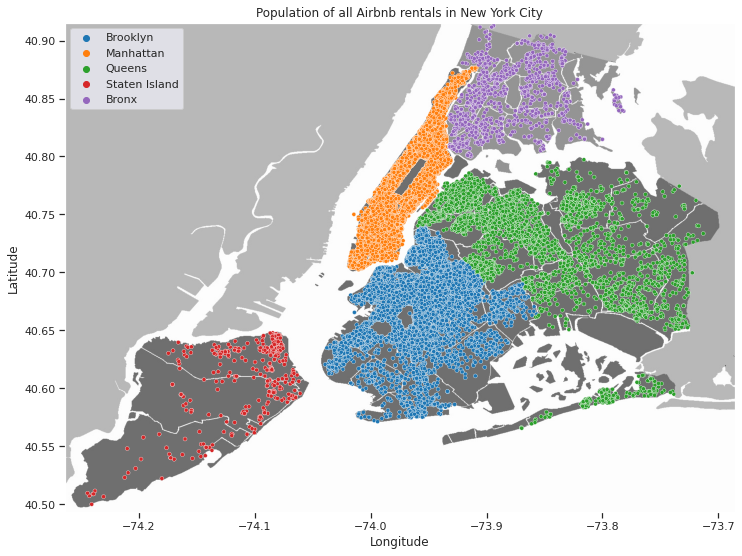

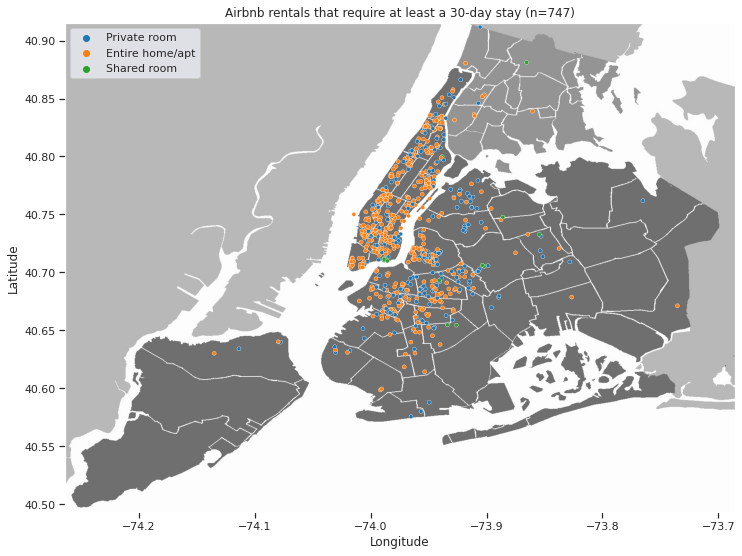

In [11]:
# Moving on to meat and potato visualizations:

# Sorting by borough, we're able to see that airbnbs cover almost every
#   available inch of New York City (not really, but there's a LOT).
#       (Tangentially: how is Staten Island part of NYC and not New Jersey? Anyone??)
#
# There are so many data points / airbnbs, though, that if we remove 
#   the map underlay, we'd still largely be able to identify all 5 boroughs! 
#   That's craaaaaaazy
#
#   The colors would probably help, but stillllllll, lol

# "Base" map -- all airbnb data points
nycMapPlot( df1, 'Borough', 
           "Population of all Airbnb rentals in New York City")

print("\n")                 # SPAAAAAAAAACE     ....                SPAAAAAAAACE

# Distribution of airbnbs that require >30 day stays
nycMapPlot( dfMinNights, 'Style', 
           "Airbnb rentals that require at least a 30-day stay (n=747)")

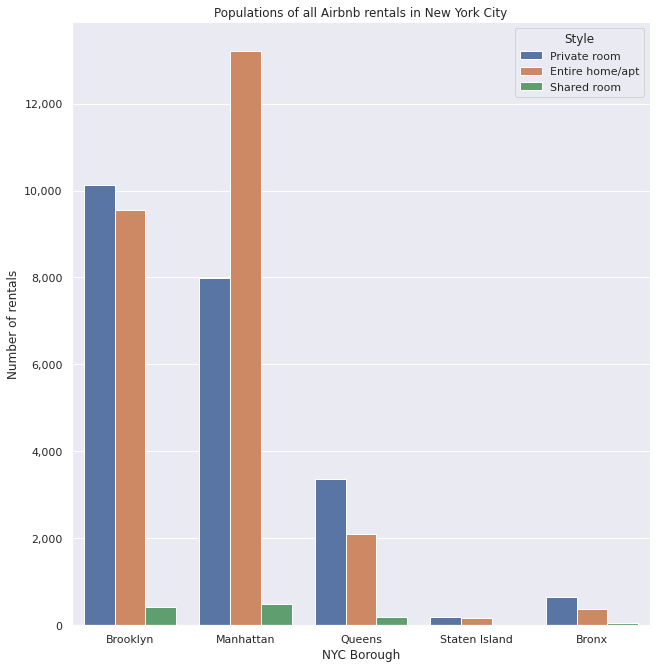

In [12]:
# Distribution of all airbnbs, by rental types
nycBarPlot( df1, 'Style', 
           "Populations of all Airbnb rentals in New York City");

In [6]:
 # The above visualizations sparked a curiosity about the prices of airbnb
 #      rentals in NYC
 df1.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

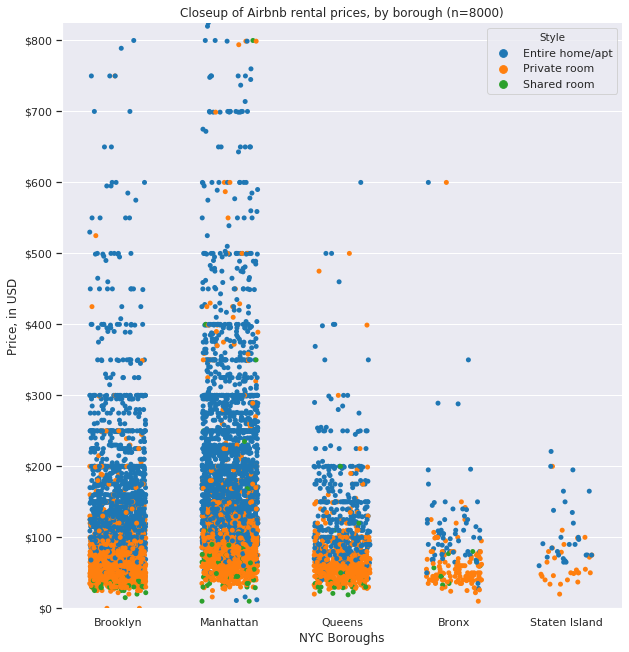

In [ ]:
# Moving on to prices by borough, by rental type

# Initial runs of this visualization with the full dataset (n=48895), even
#   with the fairly loose spread of jitter=0.25, just resulted in 
#   unidentifiable noise and solid colors top to bottom.
# Thus, after some testing and trial and error, I settled on a sample size of 
#   8,000 (~1/6 of total). 
#   While I'm not 100% certain on the inner workings of panda's .sample() 
#       method, I will assume that it works under the same statistical rules 
#       of political polling or Nielson ratings in radio & tv.
#       Therefore, a sample size of 1,000 will have a margin of error of roughly 
#       3% -- that is, there is a 95% certainty that the sum of all values will 
#       fall within +/- 3% of the values depicted by the sample.
#   Additionally, while a sample size of 1,000 airbnb properties would have 
#       been plenty, regarding statistical significance, the resultant 
#       visualization would not be as "communicatively significant" -- that is 
#       to say, it wouldn't be as interesting to look at from a lay perspective, 
#       nor would it necessarily demonstrate certain phenomena as adequately as 
#       using a higher sample size would.
#       The upshot is that using a sample size of 8,000 means that the 
#           margin of error is close to +/- 1% :)
#   This allows us to more clearly observe interesting behaviour like prices 
#       in Queens congregating around the $150 and $200 strata and 
#       $250 and $300 in Brooklyn, which lower sample sizes -- while still 
#       being statistically significant -- would not necessarily reveal as 
#       effectively, if at all.

dfPriceSample = df1.sample(8000)

nycPricePlot( dfPriceSample, 'Style',
             "Closeup of Airbnb rental prices, by borough (n=8000)")

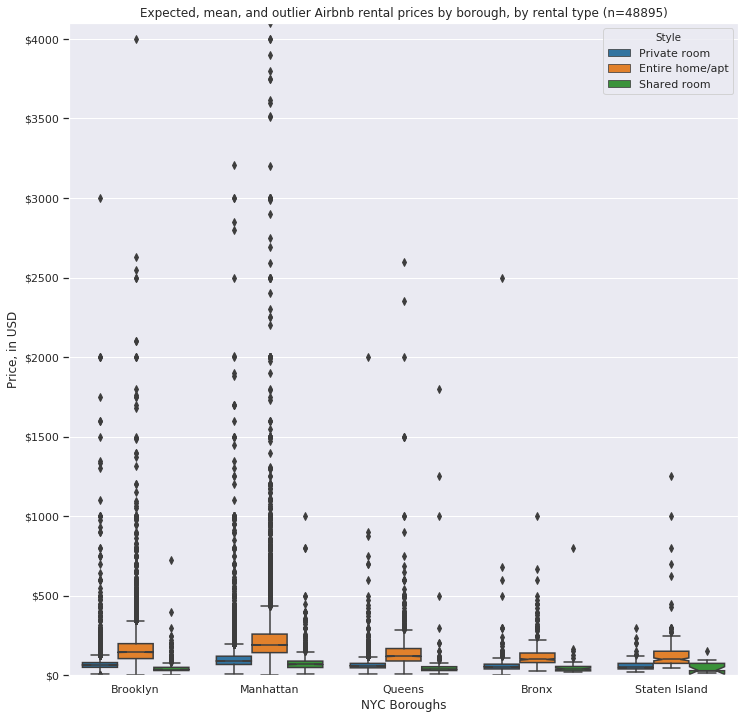

In [ ]:
# Lastly, let's look at the same data with a box plot, instead of a 
#   potentially "messy" strip plot

# Like with the strip plot, I had to limit the range of values (prices) 
#   displayed, otherwise readability would just tank. 
#   Whereas the strip plot was an almost micro look at NYC's airbnb 
#   pricing structures, a blox plot allows for a slightly more macro 
#   look at the data.
#   However, without limiting the displayed range, the 
#   innerquartile range (IQR, or the "box") would literally be just 
#   a horizontal line on the graph, due to the min and max prices
#   in the dataset being $0 and $10,000, respectively.
# That said, I chose to limit the range at $4,100 because even though
#   the max nightly price listed for 3/5 of the city's boroughs is 
#   $10,000, the majority of the data starts to heavily taper off after 
#   $4,000.
#   There are still some data points that exist at that $4,000 point,
#   so I extended it by that extra $100 to capture those points, so 
#   they don't disappear on the edge of the visualization.
# I could have set the limit $2,000 lower, at $2,100, which would have 
#   allowed for a much clearer picture of each style's IQR-and-whiskers 
#   per borough. 
#   Doing so would have also, however, come with an obvious sacrifice 
#   of the outlying data points. 
#   And considering I felt I already had a good picture of that
#   non-outlier, normal-ish distribution with the preceding strip plot, 
#   I didn't want to throw away those outlying data points.
# I didn't want to focus on them either, however. So a balance had to
#   be struck -- and that was $4,100. 
#   $4,100 was low enough to (mostly) identify the box plots -- the whisker 
#   values, the IQR, median, etc -- while preserving the greater context 
#   or picture that those outlying values provide:
#       Primarily, illustrating the differences in popularity and 
#       perceived value between the rental styles within and between 
#       each borough.

nycPriceBars( df1, 'Style',
             "Expected, mean, and outlier Airbnb rental prices by borough, by rental type (n=48895)")

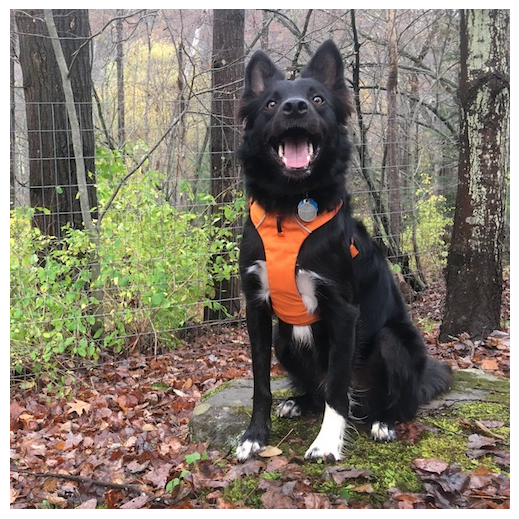

In [ ]:
# And as a bonus, here's an easter egg I discovered :)

sns.dogplot()